<a href="https://colab.research.google.com/github/saiful-kelubas-code/saiful_kelubas_DL/blob/main/dataset_car.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!kaggle datasets download saifulkelubas/dataset-car
!mkdir car

 28% 5.00M/17.9M [00:00<00:00, 31.7MB/s]
100% 17.9M/17.9M [00:00<00:00, 90.1MB/s]


In [ ]:
!unzip /content/dataset-car.zip -d /content/car

In [5]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from keras.optimizers import Adam
from pathlib import Path
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split

In [28]:
dataset_path = Path(r'/content/car/dataset_mobil')
file_path = list(dataset_path.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], file_path))

In [29]:
file_path = pd.Series(file_path).astype(str)
labels = pd.Series(labels)
df = pd.concat([file_path, labels], axis=1)
df.columns = ['image', 'label']
df.head()

,image,label
0,/content/car/dataset_mobil/Honda_Brio_Satya/br...,Honda_Brio_Satya
1,/content/car/dataset_mobil/Honda_Brio_Satya/br...,Honda_Brio_Satya
2,/content/car/dataset_mobil/Honda_Brio_Satya/br...,Honda_Brio_Satya
3,/content/car/dataset_mobil/Honda_Brio_Satya/br...,Honda_Brio_Satya
4,/content/car/dataset_mobil/Honda_Brio_Satya/br...,Honda_Brio_Satya


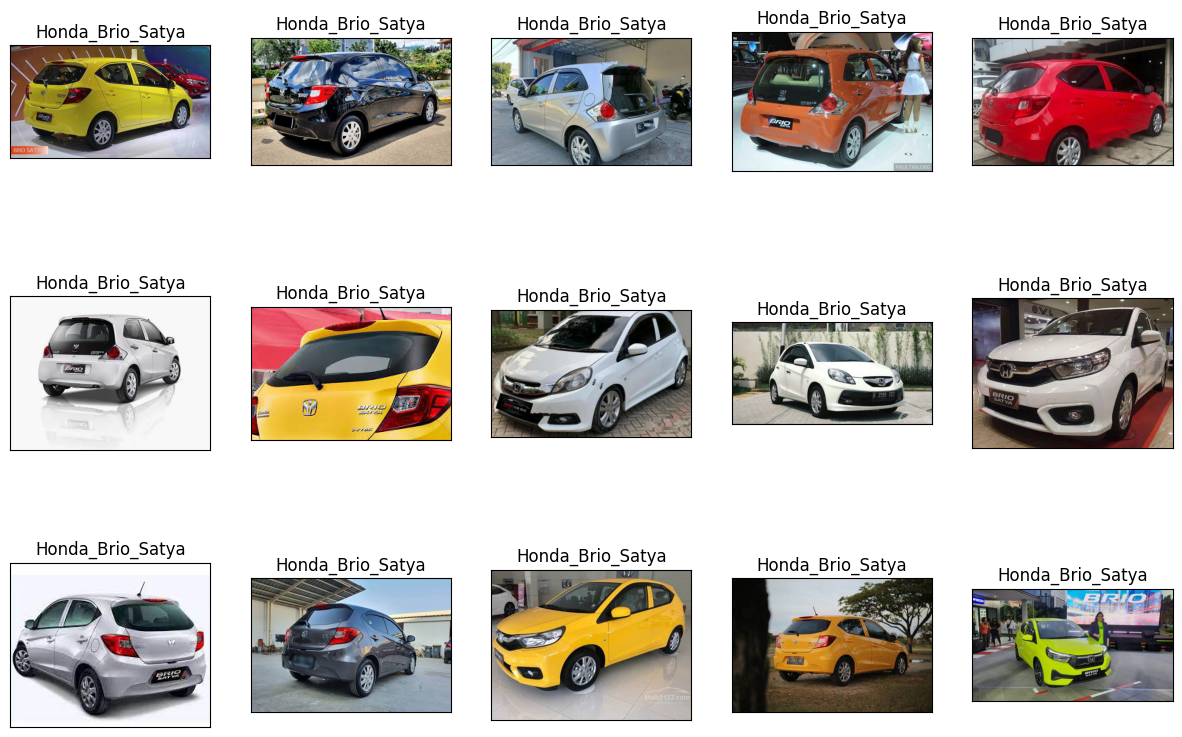

In [30]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.image[i]))
    ax.set_title(df.label[i])
    
plt.show()

In [31]:
df.label.value_counts()

Honda_Brio_Satya    100
Toyota_Agya         100
Daihatsu_Ayla       100
Name: label, dtype: int64

In [32]:
df = df[df['label'].apply(lambda x: x[-2:] != 'GT')].reset_index(drop=True)
df.label.value_counts()

Honda_Brio_Satya    100
Toyota_Agya         100
Daihatsu_Ayla       100
Name: label, dtype: int64

In [33]:
x_train, x_test = train_test_split(df, test_size=0.3,random_state=30)
x_train, x_val = train_test_split(x_train, test_size=0.2, random_state=30)

In [34]:
print("Shape of training data", x_train.shape)
print("Shape of test data", x_test.shape)
print("Shape of validation data", x_val.shape)

Shape of training data (168, 2)
Shape of test data (90, 2)
Shape of validation data (42, 2)


In [35]:
image_data_generator = ImageDataGenerator(rescale = 1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
train = image_data_generator.flow_from_dataframe(dataframe=x_train, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
test = image_data_generator.flow_from_dataframe(dataframe=x_test, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
val = image_data_generator.flow_from_dataframe(dataframe=x_val, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical',shuffle=False)

Found 168 validated image filenames belonging to 3 classes.
Found 90 validated image filenames belonging to 3 classes.
Found 42 validated image filenames belonging to 3 classes.


In [36]:
input_shape = (200, 200, 3)

In [37]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape ),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 198, 198, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 99, 99, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 97, 97, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 46, 46, 32)        18464     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 23, 23, 32)      

In [38]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])
history = model.fit(train, batch_size= 512, validation_data=val, epochs=100)

Epoch 1/100
6/6 [==============================] - 7s 838ms/step - loss: 1.1256 - accuracy: 0.2679 - val_loss: 1.0971 - val_accuracy: 0.3810
Epoch 2/100
6/6 [==============================] - 3s 480ms/step - loss: 1.0951 - accuracy: 0.3690 - val_loss: 1.0965 - val_accuracy: 0.3810
Epoch 3/100
6/6 [==============================] - 3s 460ms/step - loss: 1.1243 - accuracy: 0.3571 - val_loss: 1.0976 - val_accuracy: 0.3810
Epoch 4/100
6/6 [==============================] - 3s 468ms/step - loss: 1.0973 - accuracy: 0.3155 - val_loss: 1.0998 - val_accuracy: 0.3810
Epoch 5/100
6/6 [==============================] - 4s 631ms/step - loss: 1.1079 - accuracy: 0.3452 - val_loss: 1.0969 - val_accuracy: 0.3810
Epoch 6/100
6/6 [==============================] - 3s 474ms/step - loss: 1.1022 - accuracy: 0.3571 - val_loss: 1.0957 - val_accuracy: 0.3810
Epoch 7/100
6/6 [==============================] - 3s 552ms/step - loss: 1.0981 - accuracy: 0.3571 - val_loss: 1.0995 - val_accuracy: 0.3810
Epoch 8/100
6

In [39]:
model.save('model-1.h5')

In [40]:
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

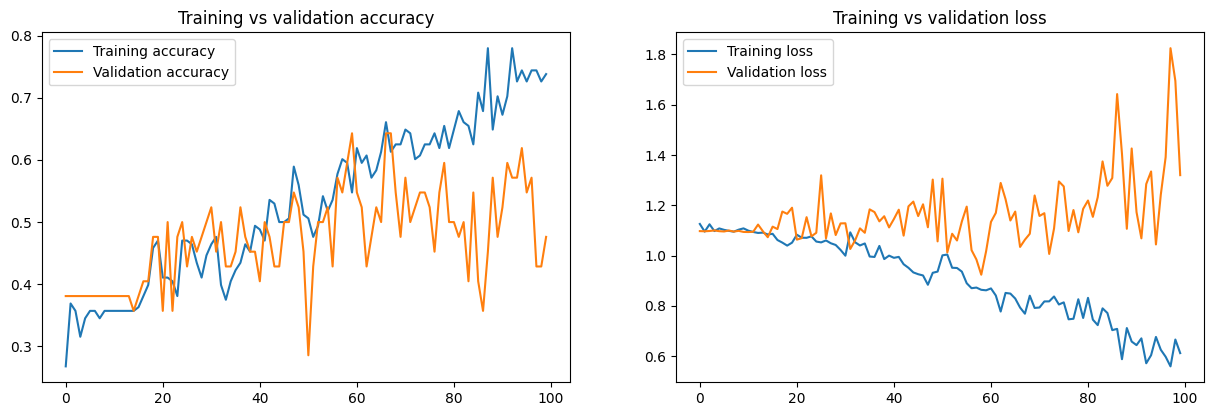

In [41]:
plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")
plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")
plt.show()

In [42]:
pred = model.predict(test)

3/3 [==============================] - 2s 601ms/step


In [43]:
pred = np.argmax(pred, axis=1)

In [44]:
labels = train.class_indices

In [45]:
labels

{'Daihatsu_Ayla': 0, 'Honda_Brio_Satya': 1, 'Toyota_Agya': 2}

In [46]:
labels = dict((v,k) for k, v in labels.items())

In [47]:
labels

{0: 'Daihatsu_Ayla', 1: 'Honda_Brio_Satya', 2: 'Toyota_Agya'}

In [48]:
y_pred = [labels[k] for k in pred]

In [49]:
print(classification_report(x_test.label, y_pred))

                  precision    recall  f1-score   support

   Daihatsu_Ayla       0.48      0.62      0.55        24
Honda_Brio_Satya       0.62      0.45      0.53        33
     Toyota_Agya       0.60      0.64      0.62        33

        accuracy                           0.57        90
       macro avg       0.57      0.57      0.56        90
    weighted avg       0.58      0.57      0.56        90



In [50]:
print(confusion_matrix(x_test.label, y_pred))

[[15  3  6]
 [10 15  8]
 [ 6  6 21]]


In [51]:
test_accuracy = model.evaluate(test)[1]

3/3 [==============================] - 1s 365ms/step - loss: 1.0590 - accuracy: 0.6000
